In [1]:
%matplotlib inline
import os
import random
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
import h5py
import math
import warnings
warnings.filterwarnings("ignore")

In [5]:
cd C:\Users\keeps\Desktop

C:\Users\keeps\Desktop


## Get the Image Data

In [45]:
with h5py.File('image227RGB.h5', 'r') as hf:
    imageInput = hf['image(227*227*3)'][:]

In [46]:
imagesArr=imageInput.reshape(400,227,227,3)

In [50]:
imagesArr.shape

(400, 227, 227, 3)

In [48]:
labelsArr=np.loadtxt('imageLabels.txt').astype(int)

## Sanity Check

rating is : 5


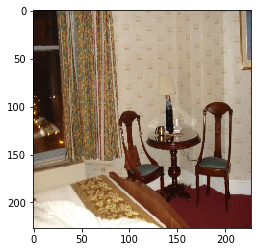

In [49]:
index = 397
plt.imshow(imagesArr[index])
print ("rating is : " + str(labelsArr[index]+1))

In [51]:
labelsArr.shape

(400,)

### Preprocess the data

### One Hot Encoding

In [52]:
def oneHotConvert(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [53]:
## My original
print("Before converting:")
print(labelsArr[:3])

Before converting:
[0 0 0]


In [54]:
## My original
oHlabelsArr = oneHotConvert(labelsArr, C = 5).T
print ("After converting: ")
print(str(oHlabelsArr))

After converting: 
[[ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 ..., 
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]]


In [55]:
oHlabelsArr.shape

(400, 5)

### Normalize Data

In [56]:
imagesArr_norm = imagesArr/255
imagesArr_norm.shape

(400, 227, 227, 3)

### Split into train and test set

In [57]:
#First, Shuffle the data
np.random.seed(0)                            # set seed
m = imagesArr_norm.shape[0]                  # number of training examples
permutation = list(np.random.permutation(m))
shuffled_imagesArr_norm = imagesArr_norm[permutation,:,:,:]
shuffled_oHlabelsArr = oHlabelsArr[permutation,:]

###Split into train and test set
testRatio=0.1
X_train=shuffled_imagesArr_norm[:int(m*(1-testRatio)),:,:,:]
Y_train=shuffled_oHlabelsArr[:int(m*(1-testRatio)),:]
X_test=shuffled_imagesArr_norm[int(m*(1-testRatio)):,:,:,:]
Y_test=shuffled_oHlabelsArr[int(m*(1-testRatio)):,:]
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 360
number of test examples = 40
X_train shape: (360, 227, 227, 3)
Y_train shape: (360, 5)
X_test shape: (40, 227, 227, 3)
Y_test shape: (40, 5)


## Sanity Check(confirm shuffle is done correctly!)

rating is : 2


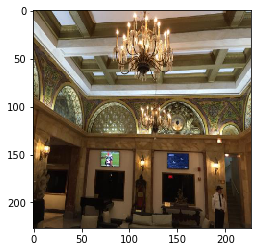

In [58]:
##Check to confirm shuffle is done correctly!
index = 397
plt.imshow(shuffled_imagesArr_norm[index])
print ("rating is : " + str(np.argmax(shuffled_oHlabelsArr[index])+1))

# Now we start building CNN (The code of building the CNN in this part is from Andrew Ng's Coursera Model but I wrote the code of tensorflow functions  )

## Create Placeholder

In [59]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    X = tf.placeholder(tf.float32, [None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, [None, n_y])
    return X, Y

## initialize_parameters

In [93]:
def initialize_parameters():

    tf.set_random_seed(1)                         
    W1 = tf.get_variable("W1", [11, 11, 3, 96], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2", [5, 5, 96, 256], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [72]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    W2 = parameters['W2']
    
  
    Z1 = tf.nn.conv2d(X, W1, strides=[1, 4, 4, 1], padding='VALID')
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize = [1, 8, 8, 1], strides = [1, 8, 8, 1], padding='SAME')
    Z2 = tf.nn.conv2d(P1, W2, strides=[1, 2, 2, 1], padding='VALID')
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize = [1, 4, 4, 1], strides = [1, 4, 4, 1], padding='SAME')
    P = tf.contrib.layers.flatten(P2)
    Z3 = tf.contrib.layers.fully_connected(P, 512, activation_fn=None)
    Z4 = tf.contrib.layers.fully_connected(Z3, 512, activation_fn=None)
    Z5 = tf.contrib.layers.fully_connected(Z4, 24, activation_fn=None)
    Z6 = tf.contrib.layers.fully_connected(Z5, 5, activation_fn=None)

    return Z6

## Compute Cost

In [61]:
def compute_cost(Z6, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z6, labels=Y)) 
    return cost

## Random Mini Batch

In [62]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    m = X.shape[0]                  
    mini_batches = []
    np.random.seed(seed)
    
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    num_complete_minibatches = math.floor(m/mini_batch_size) 
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [71]:
def model_with_L2(X_train, Y_train, X_test, Y_test, lambd=0.1,minibatch_size = 64,num_epochs = 30, learning_rate = 0.009,print_cost = True):
    
    ops.reset_default_graph()                        
    tf.set_random_seed(1)                            
    seed = 3                                          
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                       
    trainAccuracy=[]
    testAccuracy=[]
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    parameters = initialize_parameters()
    W1 = parameters['W1']
    W2 = parameters['W2']
   
    Z6 = forward_propagation(X, parameters)
    
    cost = compute_cost(Z6, Y)
    if (lambd!=0):
        reg = tf.nn.l2_loss(W1)+tf.nn.l2_loss(W2)
        cost = tf.reduce_mean(cost + reg * lambd)
 
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    init = tf.global_variables_initializer()
     
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) 
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                minibatch_cost += temp_cost / num_minibatches
                

        
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
            if print_cost == True and epoch % 1 == 0:
                predict_op = tf.argmax(Z6, 1)
                correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
                accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
                train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
                test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
                trainAccuracy.append(train_accuracy)
                testAccuracy.append(test_accuracy)
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
                print("Train Accuracy:", train_accuracy)
                print("Test Accuracy:", test_accuracy)     
          
                
                
        
       
        plt.plot(np.squeeze(costs))
        plt.ylabel('Cost')
        plt.legend(['Cost'],loc='upper right')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
  
        plt.plot(np.squeeze(trainAccuracy))
        plt.plot(np.squeeze(testAccuracy))
        plt.legend(['Training Set Accuracy', 'Test Set Accuracy'], loc='upper left')
        plt.ylabel('Training Accuracy and Test Accuracy')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

       
        predict_op = tf.argmax(Z6, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        

        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

## No Regularization, mini batch size of 64, 100 epochs

Cost after epoch 0: 162.876251
Train Accuracy: 0.136111
Test Accuracy: 0.125
Cost after epoch 5: 2.015688
Train Accuracy: 0.338889
Test Accuracy: 0.4
Cost after epoch 10: 1.915137
Train Accuracy: 0.338889
Test Accuracy: 0.4
Cost after epoch 15: 1.908017
Train Accuracy: 0.183333
Test Accuracy: 0.1
Cost after epoch 20: 1.945345
Train Accuracy: 0.338889
Test Accuracy: 0.4
Cost after epoch 25: 1.856163
Train Accuracy: 0.338889
Test Accuracy: 0.4
Cost after epoch 30: 1.885798
Train Accuracy: 0.338889
Test Accuracy: 0.4
Cost after epoch 35: 1.846999
Train Accuracy: 0.338889
Test Accuracy: 0.4
Cost after epoch 40: 1.883395
Train Accuracy: 0.183333
Test Accuracy: 0.1
Cost after epoch 45: 1.871277
Train Accuracy: 0.338889
Test Accuracy: 0.4
Cost after epoch 50: 1.844074
Train Accuracy: 0.338889
Test Accuracy: 0.4
Cost after epoch 55: 1.857531
Train Accuracy: 0.338889
Test Accuracy: 0.4
Cost after epoch 60: 1.891161
Train Accuracy: 0.183333
Test Accuracy: 0.1
Cost after epoch 65: 1.848648
Train 

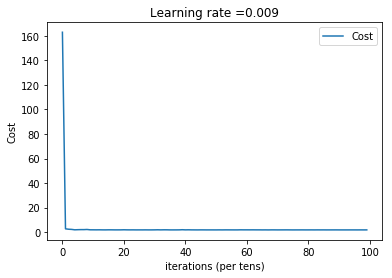

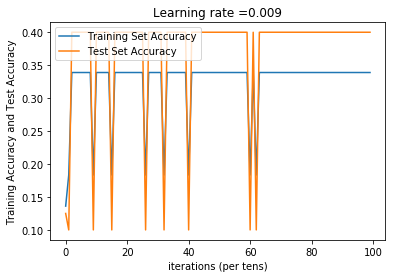

Train Accuracy: 0.338889
Test Accuracy: 0.4


In [73]:
_, _, parameters1 = model_with_L2(X_train, Y_train, X_test, Y_test,0,64,100)